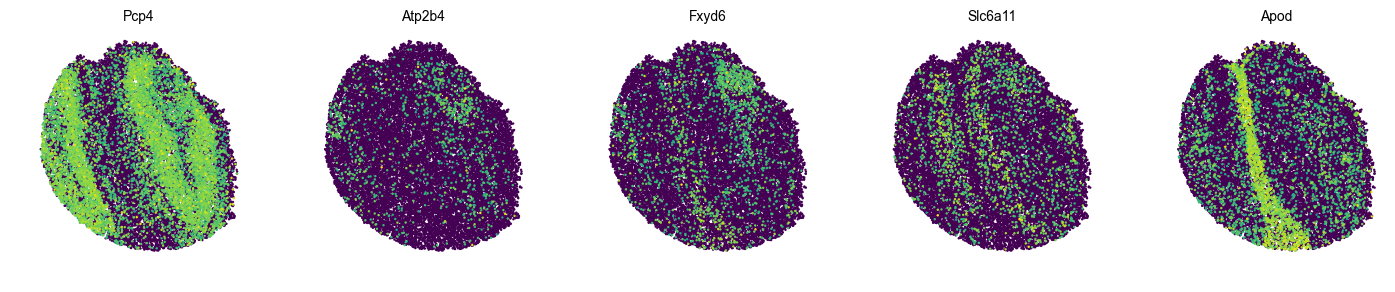

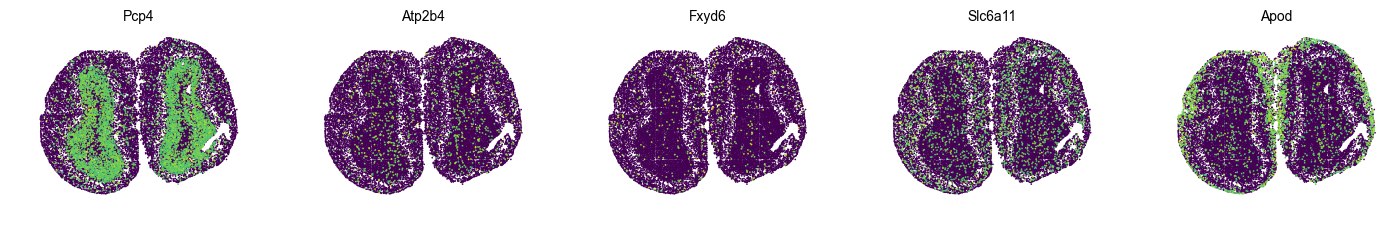

In [13]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import scanpy as sc
import numpy as np
import scipy.sparse
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import os
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
# 设置中文字体显示
# plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题




# 5. 空间可视化 - 展示组织切片上的基因表达
def visualize_spatial_expression(genes_to_plot, adata, save_prefix='spatial_gene'):
    """
    可视化基因在空间组织上的表达（不依赖sc.pl.spatial）

    参数:
    - genes_to_plot: 要可视化的基因列表
    - adata: AnnData对象
    - save_prefix: 保存图片的前缀
    """
    print(f"正在可视化基因: {genes_to_plot}")
    
    # 获取空间坐标
    if 'spatial' in adata.obsm:
        spatial_coords = adata.obsm['spatial']
    else:
        print("错误：未找到空间坐标数据！")
        return
    
    # 创建一个大的图形
    n_genes = len(genes_to_plot)
    fig, axes = plt.subplots(1, n_genes, figsize=(5 * n_genes, 5))

    if n_genes == 1:
        axes = [axes]  # 确保axes始终是列表

    for i, gene in enumerate(genes_to_plot):
        if gene in adata.var_names:
            # 获取基因表达值
            expression = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, 'toarray') else adata[:, gene].X.flatten()
            
            # 绘制散点图
            scatter = axes[i].scatter(
                spatial_coords[:, 0],  # X坐标
                -spatial_coords[:, 1],  # Y坐标
                c=expression,         # 基因表达值
                cmap='viridis',       # 颜色映射
                s=10,                 # 点大小
                alpha=0.8
            )
            
            # 设置标题和坐标轴
            axes[i].set_title(gene)
            axes[i].set_aspect('equal')
            axes[i].axis('off')
            
            # 添加颜色条
            cbar = plt.colorbar(scatter, ax=axes[i])
            cbar.set_label('Expression')
        else:
            axes[i].text(0.5, 0.5, f"{gene} 不在数据中", ha='center', va='center')
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(f"{save_prefix}_{'_'.join(genes_to_plot)}.png", dpi=300, bbox_inches='tight')
    plt.show()

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np


# 假设adata已经加载
# adata = sc.read_h5ad("your_data.h5ad")

def visualize_heart_class(adata, groupby='cell_type', heart_class='Heart', save_path=None):
    """
    可视化空间转录组数据，只染色Heart类细胞

    参数:
    adata: AnnData对象，包含空间转录组数据
    groupby: 用于分组的列名，默认为'cell_type'
    heart_class: Heart类的标签名称，默认为'Heart'
    save_path: 保存图像的路径，若为None则不保存
    """
    # 确保数据中有空间坐标
    if 'spatial' not in adata.obsm:
        raise ValueError("数据中没有空间坐标，请确保adata.obsm['spatial']存在")

    # 确保数据中有分组信息
    if groupby not in adata.obs:
        raise ValueError(f"数据中没有{groupby}列，请确保分组信息存在")

    # 创建一个新的分组列，将Heart类标记为1，其他标记为0
    adata.obs['heart_indicator'] = np.where(adata.obs[groupby] == heart_class, heart_class, 'Other')

    # 设置颜色映射，Heart类使用特定颜色，其他细胞类型使用灰色
    palette = {heart_class: 'red', 'Other': 'lightgray'}

    sc.pl.spatial(
        adata,
        color='heart_indicator',
        library_key="images",
        palette=palette,
        spot_size=1,
        alpha_img=0.5,
        show=False,
        colorbar_loc=None  # 关闭颜色条
    )

    plt.axis('off')  # 关闭坐标轴

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)

    plt.show()

# 使用示例
# visualize_heart_class(adata, groupby='cell_type', heart_class='Heart', save_path='heart_spatial.png')

import matplotlib.pyplot as plt
import scanpy as sc

plt.rcParams['font.family'] = 'Arial'
coord_keys = ('xcoord', 'ycoord', 'spatial')
Batch_list = []
input_dir = os.path.join('data', 'MOB')
# 获取目录下所有文件
all_files = os.listdir(input_dir)

import anndata
# 过滤出所有 .h5ad 文件
h5ad_files = [f for f in all_files if f.endswith('.h5ad')]
import os
import matplotlib.pyplot as plt
import scanpy as sc

Batch_list = []  # 确保提前定义

for h5ad_file in h5ad_files:
    file_path = os.path.join(input_dir, h5ad_file)
    adata = sc.read_h5ad(file_path)
    
    # 数据预处理
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e7)
    sc.pp.log1p(adata)
    
    genes_of_interest2 = ['Pcp4','Atp2b4','Fxyd6','Slc6a11','Apod'] 
    n_genes = len(genes_of_interest2)
    
    # 创建子图（1行n列）
    fig, axes = plt.subplots(
        1, n_genes, 
        figsize=(3.5 * n_genes, 3.5),
        gridspec_kw={"wspace": 0.3}
    )
    
    # 确保axes可迭代（单基因时转换为列表）
    if n_genes == 1:
        axes = [axes]
    
    # 绘制每个基因的空间表达图
    for i, gene in enumerate(genes_of_interest2):
        # 绘制当前基因到第i个子图
        sc.pl.spatial(
            adata, 
            color=gene, 
            ax=axes[i],  # 明确指定当前子图的轴
            spot_size=50,
            show=False,
            legend_loc=None  # 不显示图例
        )
        
        # 设置当前子图的标题（基因名）
        axes[i].set_title(gene, fontsize=10)
        
        # 1. 移除颜色条（若存在）
        for c in axes[i].get_children():
            if hasattr(c, 'colorbar') and c.colorbar is not None:
                c.colorbar.remove()
        
        # 2. 移除图例（若存在）
        if axes[i].get_legend() is not None:
            axes[i].get_legend().remove()
        
        # 3. 清空x/y轴标签
        axes[i].set_xlabel(' ')
        axes[i].set_ylabel(' ')
        
        # 4. 隐藏边框（轴脊柱）
        for spine in axes[i].spines.values():
            spine.set_visible(False)
        
        # 5. 隐藏刻度
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    
    # 调整布局并保存
    plt.tight_layout()
    pdf_filename = f"{os.path.splitext(h5ad_file)[0]}_expression_for_50.pdf"
    plt.savefig(
        pdf_filename, 
        format='pdf', 
        bbox_inches='tight', 
        dpi=1000
    )
    
    plt.show()
    Batch_list.append(adata)



In [2]:
adata_concat = ad.concat(Batch_list, label="slice_name")
adata_concat.obs


,slice_name
AAAAAAACAAAAGG,0
AAAAAACATCCTAT,0
AAAAAACCACTTGT,0
AAAAAACCTTTTTT,0
AAAAAAGAAAACGA,0
...,...
Spot_9994,1
Spot_9995,1
Spot_9996,1
Spot_9998,1


In [3]:
import scanpy as sc
import pandas as pd

# 生成新索引的 Series，通过 where 条件判断来赋值
new_indices = adata_concat.obs.index.where(
    adata_concat.obs['slice_name'] != '0',  # 条件：slice_name 不等于 '0' 时，保留原索引
    other='1_' + adata_concat.obs.index +'_Slide-seqV2' # 条件不满足（即 slice_name 等于 '0'）时，添加前缀 '0-'
)

# 替换索引
adata_concat.obs_names = new_indices
adata_concat.obs.index = new_indices

new_indices = adata_concat.obs.index.where(
    adata_concat.obs['slice_name'] != '1',  # 条件：slice_name 不等于 '0' 时，保留原索引
    other='0_' + adata_concat.obs.index +'_Stereo-seq' # 条件不满足（即 slice_name 等于 '0'）时，添加前缀 '0-'
)

# 替换索引
adata_concat.obs_names = new_indices
adata_concat.obs.index = new_indices


adata_concat.obs

,slice_name
1_AAAAAAACAAAAGG_Slide-seqV2,0
1_AAAAAACATCCTAT_Slide-seqV2,0
1_AAAAAACCACTTGT_Slide-seqV2,0
1_AAAAAACCTTTTTT_Slide-seqV2,0
1_AAAAAAGAAAACGA_Slide-seqV2,0
...,...
0_Spot_9994_Stereo-seq,1
0_Spot_9995_Stereo-seq,1
0_Spot_9996_Stereo-seq,1
0_Spot_9998_Stereo-seq,1


In [4]:
import scanpy as sc
adata = sc.read_h5ad('MOB.h5ad')
adata.obs

,slice_labels,leiden
0_Spot_1_Stereo-seq,Stereo-seq,2
0_Spot_10_Stereo-seq,Stereo-seq,2
0_Spot_100_Stereo-seq,Stereo-seq,2
0_Spot_1000_Stereo-seq,Stereo-seq,2
0_Spot_10000_Stereo-seq,Stereo-seq,2
...,...,...
1_TTTTTTTTTCTCTT_Slide-seqV2,Slide-seqV2,1
1_TTTTTTTTTGGATT_Slide-seqV2,Slide-seqV2,1
1_TTTTTTTTTGTATT_Slide-seqV2,Slide-seqV2,1
1_TTTTTTTTTTGTCT_Slide-seqV2,Slide-seqV2,0


In [5]:
common_cells = adata.obs_names.intersection(adata_concat.obs_names)
assert len(common_cells) == len(adata.obs_names), "ID 仍未完全匹配！"

In [7]:
adata_concat.obs['leiden']=adata.obs['leiden']
adata_concat.obs['slice_labels']=adata.obs['slice_labels']
adata_concat.obs

,slice_name,leiden,slice_labels
1_AAAAAAACAAAAGG_Slide-seqV2,0,1,Slide-seqV2
1_AAAAAACATCCTAT_Slide-seqV2,0,0,Slide-seqV2
1_AAAAAACCACTTGT_Slide-seqV2,0,0,Slide-seqV2
1_AAAAAACCTTTTTT_Slide-seqV2,0,1,Slide-seqV2
1_AAAAAAGAAAACGA_Slide-seqV2,0,6,Slide-seqV2
...,...,...,...
0_Spot_9994_Stereo-seq,1,2,Stereo-seq
0_Spot_9995_Stereo-seq,1,2,Stereo-seq
0_Spot_9996_Stereo-seq,1,2,Stereo-seq
0_Spot_9998_Stereo-seq,1,2,Stereo-seq


小提琴图已保存至: violin_plots_genes.pdf


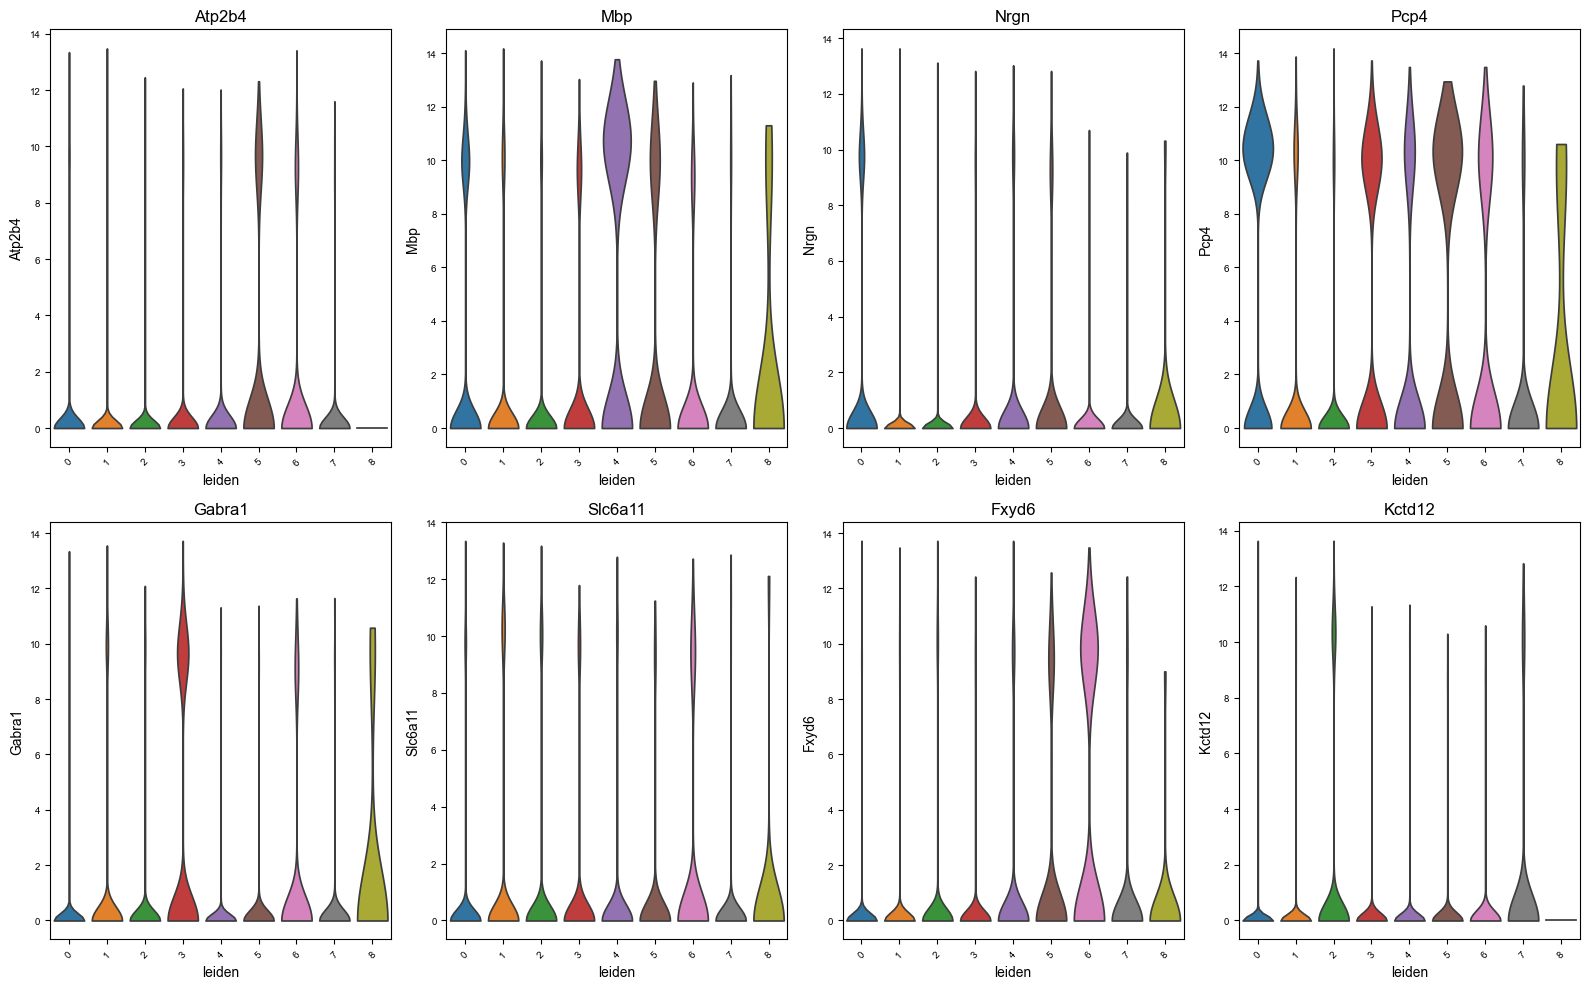

In [16]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

def plot_genes_in_grid(adata, genes, groupby='leiden', n_cols=4, figsize_per_plot=(3.5, 3.5), 
                       save_path=None, dpi=300, **kwargs):
    """
    绘制基因表达小提琴图网格，并支持保存为PDF文件。
    
    Parameters:
        adata: AnnData对象，包含单细胞数据
        genes: 待绘制的基因列表
        groupby: adata.obs中用于分组的列（如'leiden'聚类结果）
        n_cols: 每行显示的子图数量（默认4个）
        figsize_per_plot: 单个子图的尺寸（宽, 高），默认(4, 5)
        save_path: PDF文件保存路径（如为None则不保存，仅显示）
        dpi: 保存图片的分辨率（默认300，高分辨率可用600/1000）
        **kwargs: 传递给sc.pl.violin的额外参数（如rotation、stripplot等）
    """
    # 计算网格布局（行数 = 总基因数 ÷ 每行列数，向上取整）
    n_genes = len(genes)
    n_rows = (n_genes + n_cols - 1) // n_cols  # 向上取整公式
    
    # 创建画布（总尺寸 = 单图尺寸 × 行列数）
    total_width = figsize_per_plot[0] * n_cols
    total_height = figsize_per_plot[1] * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(total_width, total_height))
    
    # 确保axes是2D数组（兼容单 row/单 column 场景，避免索引错误）
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])  # 单个子图时转为2D数组
    elif n_rows == 1:
        axes = axes.reshape(1, -1)  # 单行时转为(1, n_cols)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)  # 单列时转为(n_rows, 1)
    
    # 隐藏未使用的子图（若总子图数 > 基因数）
    for i in range(n_genes, n_rows * n_cols):
        row, col = divmod(i, n_cols)  # 计算未使用子图的行列索引
        axes[row, col].axis('off')  # 关闭轴显示（空白）
    
    # 循环绘制每个基因的小提琴图
    for i, gene in enumerate(genes):
        row, col = divmod(i, n_cols)  # 当前基因的子图行列索引
        ax = axes[row, col]  # 获取当前子图的轴对象
        
        # 绘制小提琴图（指定ax，不自动显示）
        sc.pl.violin(
            adata, 
            keys=gene,  # 待绘制的基因（scanpy 1.9+建议用keys参数，兼容旧版color）
            groupby=groupby, 
            stripplot=False,  # 不显示散点（避免拥挤，可按需改为True）
            ax=ax, 
            show=False,  # 关闭自动显示，统一由plt.show()控制
            **kwargs  # 传递额外参数（如rotation调整x标签旋转）
        )
        
        # 优化子图标题和标签
        ax.set_title(gene, fontsize=12)  # 子图标题为基因名（调整字体大小）
        ax.set_xlabel(groupby, fontsize=10)  # x轴标签为分组列名（如'leiden'）
        ax.tick_params(axis='x', labelsize=7)  # 缩小x轴分组标签字体
        ax.tick_params(axis='y', labelsize=7)  # 缩小y轴表达量标签字体
    
    # 调整子图间距（避免标签重叠）
    plt.tight_layout()
    
    # 保存为PDF文件（若指定save_path）
    if save_path is not None:
        # 确保保存路径包含.pdf后缀（若用户未添加）
        if not save_path.endswith('.pdf'):
            save_path += '.pdf'
        plt.savefig(
            save_path,
            format='pdf',  # 明确保存格式为PDF
            bbox_inches='tight',  # 去除图片周围多余空白
            pad_inches=0.1,  # 保留少量内边距（避免标签被截断）
            dpi=dpi  # 分辨率（默认300，高清图可设为600）
        )
        print(f"小提琴图已保存至: {save_path}")
    
    # 显示图片（若仅需保存不显示，可注释此句）
    plt.show()


# --------------------------
# 示例调用（含PDF保存）
# --------------------------
if __name__ == "__main__":
    # 1. 假设adata_concat已加载并预处理（需替换为你的数据加载逻辑）
    # adata_concat = sc.read_h5ad("path/to/your/adata_concat.h5ad")
    
    # 2. 定义待绘制的基因列表
    genes = ['Atp2b4', 'Mbp', 'Nrgn', 'Pcp4', 'Gabra1', 'Slc6a11', 'Fxyd6', 'Kctd12']
    
    # 3. 调用函数绘制并保存PDF
    plot_genes_in_grid(
        adata=adata_concat,
        genes=genes,
        groupby='leiden',  # 按leiden聚类分组
        n_cols=4,  # 每行显示4个基因
        figsize_per_plot=(4, 5),  # 单个子图尺寸（宽4，高5）
        save_path="violin_plots_genes.pdf",  # 保存路径（可自定义）
        dpi=600,  # 高分辨率（适合论文/报告）
        rotation=45  # x轴分组标签旋转45度（避免重叠）
    )

In [5]:
import scanpy as sc
import numpy as np

# 假设 adata 是你的 AnnData 对象
# 方法一：将 X 转换为 numpy 数组后检查
if hasattr(adata_concat.X, 'toarray'):  # 检查是否是稀疏矩阵
    x_array = adata_concat.X.toarray()
else:
    x_array = adata_concat.X

has_negative = np.any(x_array < 0)
if has_negative:
    print("adata.X 中存在负值")
else:
    print("adata.X 中不存在负值")

adata.X 中不存在负值
